In [30]:
import os
import pandas as pd
import numpy as np
import gzip
import json
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from article_dataset import ArticleDataset

from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [32]:
LABEL = 'major_topic_pred_index'
ARTICLE = 'article'

In [33]:
def read_folder(folder_path):
    dataframes = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jsonl.gz'):
            with gzip.open(os.path.join(folder_path, filename), 'rt', encoding='utf-8') as file:
                for line in file:
                    json_data = json.loads(line)
                    df = pd.DataFrame(json_data)
                    dataframes.append(df)
    if dataframes:
        aggregated_df = pd.concat(dataframes, ignore_index=True)
        return aggregated_df
    else:
        print("No jsonl files found in the directory.")
        return None
    
def reduce(_number=6):
    # csak a test
    test = os.path.join(os.getcwd(), 'test')
    df = read_folder(test)
    df.drop('uuid', axis=1, inplace=True)
    return df.groupby('major_topic_pred').apply(lambda x: x.sample(n=min(_number, len(x)))).reset_index(drop=True)


df_train = reduce()
df_test = reduce(3)
df_eval = reduce(3)

print(df_train.index)
print(df_test.index)
print(df_eval.index)

labels = df_train['major_topic_pred'].unique().tolist()
number_of_labels = len(labels)
id_to_label = {_id: label for _id, label in enumerate(labels)}
label_to_id = {label: _id for _id, label in enumerate(labels)}


df_train[LABEL] = df_train['major_topic_pred'].map(lambda x: label_to_id[x])
df_test[LABEL] = df_test['major_topic_pred'].map(lambda x: label_to_id[x])
df_eval[LABEL] = df_eval['major_topic_pred'].map(lambda x: label_to_id[x])

RangeIndex(start=0, stop=132, step=1)
RangeIndex(start=0, stop=66, step=1)
RangeIndex(start=0, stop=66, step=1)


In [34]:
df_train.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,A rendkívüli forintgyengülés repíti a Richter ...,Az elemzői várakozásokat minden szinten meghal...,Minden szinten az elemzői konszenzust felülmúl...,portfolio.hu,https://www.portfolio.hu/uzlet/20220803/a-rend...,2022-08-03T02:51:00,2022-08-10T02:11:42,"gyorsjelentés,",0.860217,1,0
1,Hatalmas deficittel birkózik az USA,Az Egyesült Államok költségvetési hiánya idén ...,"A kormány költségvetési hivatala 2010-re 1,47 ...",index.hu,http://index.hu/gazdasag/vilag/2010/07/27/hata...,2010-07-27T06:53:00,2017-11-20T00:40:35,költségvetés,0.731257,1,0
2,Három mûszakban dolgozik a kapuvári üzem,Kapuvár–Beled - Az utóbbi három évben több min...,Idei fejlesztéseik középpontjában a beledi üze...,kisalfold.hu,http://www.kisalfold.hu/rabakozi_hirek/harom_m...,2009-09-15T08:01:00,2017-10-19T11:23:22,Beled,0.793503,1,0
3,Alapos megütötték a bitcoint - Az amerikai tőz...,A hétvégi G7-csúcstalálkozó nagy adómegállapod...,2021. június 08. 22:45\n\nNem volt egységes ir...,portfolio.hu,https://www.portfolio.hu/uzlet/20210608/alapos...,2021-06-08T22:45:00,2021-06-15T04:20:35,"részvénypiac,",0.620573,1,0
4,Fejvesztve menekítik a magyarok a pénzüket az ...,A magas infláció miatt nagyon is érthető átren...,Számos érdekesség kirajzolódik az MNB előzetes...,portfolio.hu,https://www.portfolio.hu/befektetes/20230518/f...,2023-05-18T10:59:00,2023-05-31T00:22:17,"befektetési alap,",0.682144,1,0


In [35]:
df_test.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Galambos Lajos nagyon lefogyott – ez a szilves...,Minden csatorna készül valami szilveszteri műs...,"Még ősszel mesélt Galambos Lajos arról, hogy f...",nlc.hu,https://nlc.hu/sztarok/20201229/galambos-lajos...,None,2021-02-25T11:25:37,Galambos Lajos Lagzi Lajcsi Life TV szilveszte...,0.206171,1,0
1,Hogyan játsszuk ki a vagyonellenőrzést?,Alkotmányellenes és nemzetközi megállapodásba ...,"""A téma mindannyiunkat érintő ügy"" – mondta ál...",index.hu,https://index.hu/gazdasag/magyar/vgyn070312/,2007-03-12T14:18:00,2021-01-22T23:10:10,Magyar,0.649183,1,0
2,Az adósságcsökkentés apasztotta a devizatartal...,A majdnem kétmilliárd euró értékű kötvénytarto...,"A tartalékok csökkenését az magyarázza, hogy j...",origo.hu,https://www.origo.hu/gazdasag/20200211-adossag...,2020-02-11T11:35:00,2022-08-10T19:41:00,devizatartalék,0.717533,1,0
3,Szaúd-Arábiában bebörtönzött nőjogi aktivisták...,A társadalmi helyzetükre vonatkozó sztereotípi...,A szaúdi hatóságok több mint egy tucat nőjogi ...,bama.hu,https://www.bama.hu/orszag-vilag/szaud-arabiab...,2018-10-12T16:44:00,2019-06-26T21:56:38,halálbüntetés,0.470580,2,1
4,Diszkriminációról beszélnek a repülõrõl leszál...,Egy duplán eladott ülés miatt alakult ki a vit...,Több utast leszállítottak a Spirit Airlines Lo...,origo.hu,https://www.origo.hu/utazas/20151103-diszkrimi...,2015-11-03T14:15:00,2019-11-18T17:01:27,utazás,0.396952,2,1


In [36]:
df_eval.head()

,title,lead,article,domain,url,date_of_creation,cc_date,tags,doc_similarity,major_topic_pred,major_topic_pred_index
0,Felére csökkent a Volkswagen nyeresége,A Volkswagen harmadik negyedéves nyeresége köz...,A gyár nettó profitja 439 millió euróra csökke...,origo.hu,https://www.origo.hu/gazdasag/hirek/20021030fe...,2002-10-30T11:07:00,2019-05-27T12:36:13,Volkswagen AG,0.823234,1,0
1,L. Simon: Nem az RTL Klub ellen van a reklámtö...,Az internetes tartalomszolgáltatók adóköteleze...,A reklámtörvénnyel kapcsolatban az internetes ...,hvg.hu,https://hvg.hu/gazdasag/20140805_L_Simon_nem_a...,2014-08-05T05:29:00,2021-04-21T22:57:05,L. Simon László,0.825578,1,0
2,Európába jött a mindent verő új Tesla Roadster,Az első példány hófehér fényezéssel érkezett m...,"A Tesla nagyot durrantott azzal, hogy tavaly n...",hvg.hu,https://hvg.hu/cegauto/20180907_europaba_jott_...,2018-09-07T11:21:00,2020-12-05T12:38:34,e-autó,0.181144,1,0
3,Nem nézett rá a megtámadott cigány asszony a r...,Először találkozhattak a cigányok elleni támad...,A cigányok elleni támadássorozat első roma sér...,origo.hu,https://www.origo.hu/itthon/20110518-nem-nezet...,2011-05-18T11:10:00,2022-11-28T01:54:23,cigányok elleni támadások,0.647014,2,1
4,A spárga és a kucsmagomba szerelme,Ahogy a legjobb zsidóvicceket mindig zsidók mo...,Melegviccekben erősen nyit a moziév. Guy Ritch...,index.hu,http://index.hu/kultur/cinematrix/kritika/mele...,2009-01-05T11:15:00,2017-12-13T10:10:59,Kritika,0.408078,2,1


In [37]:
id_to_label, label_to_id

({0: 1,
  1: 2,
  2: 3,
  3: 4,
  4: 5,
  5: 6,
  6: 7,
  7: 8,
  8: 9,
  9: 10,
  10: 12,
  11: 13,
  12: 14,
  13: 15,
  14: 16,
  15: 17,
  16: 18,
  17: 19,
  18: 20,
  19: 21,
  20: 23,
  21: 999},
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  12: 10,
  13: 11,
  14: 12,
  15: 13,
  16: 14,
  17: 15,
  18: 16,
  19: 17,
  20: 18,
  21: 19,
  23: 20,
  999: 21})

In [38]:
BERT_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME, return_tensors='pt')

In [39]:
sample_row = df_train.iloc[0]
sample_article = sample_row[ARTICLE]
sample_label = sample_row[LABEL]

print(sample_article)
print("label: ", sample_label)

Minden szinten az elemzői konszenzust felülmúló második negyedéves eredményekről számolt be ma hajnalban közzétett gyorsjelentésében a Richter. A bevétel és az adózott eredmény új negyedéves rekordot állított fel, a profit a legoptimistább elemzői várakozásokat is meghaladta.
Az erős negyedévhez a cég számára kedvező devizaárfolyam-környezet, a forintgyengülés, a specializált termékek stabil növekedése és egy egyszeri mérföldkő-bevétel is hozzájárult.
A lezárt negyedév eredményei mellett legalább olyan fontos, hogy mit mond a menedzsment a kilátásokkal kapcsolatban. A cégvezetés februárban, az orosz-ukrán háború kitörését követően pesszimistább lett az idei évre, egy nemrégiben adott interjúban azonban Orbán Gábor már optimistább volt, nyilatkozata szerint olyan helyzetben van a Richter, hogy teljesíteni tudja az eredeti üzleti tervet. (Eredetileg a vállalat forintban kifejezve 10 százalékos bevétel-és nyereségnövekedést célzott meg 2022-re.)
A világgazdasági környezetben tapasztalható

In [40]:
encoding = tokenizer.encode_plus(
  sample_article,
  add_special_tokens=True,
  max_length=1024,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [41]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 2525]), torch.Size([1, 2525]))

In [42]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'mind', '##en', 's', '##zin', '##ten', 'az', 'el', '##em', '##zo', '##i', 'ko', '##ns', '##zen', '##zu', '##st', 'fe', '##lu', '##lm', '##ulo']


In [43]:
token_counts = []

for _, row in df_train.iterrows():
    token_count = len(tokenizer.encode(
        row[ARTICLE], 
        max_length=512, 
        truncation=True
    ))
    token_counts.append(token_count)

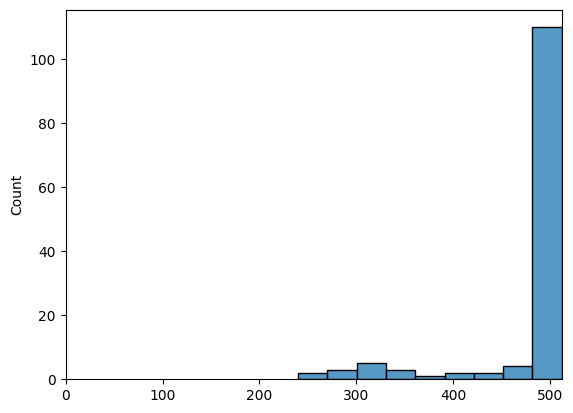

In [44]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [45]:
MAX_TOKEN_COUNT = 512

In [46]:


train_dataset = ArticleDataset(
  df_train,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['article', 'input_ids', 'attention_mask', 'label'])

In [47]:
sample_item

{'article': 'Minden szinten az elemzői konszenzust felülmúló második negyedéves eredményekről számolt be ma hajnalban közzétett gyorsjelentésében a Richter. A bevétel és az adózott eredmény új negyedéves rekordot állított fel, a profit a legoptimistább elemzői várakozásokat is meghaladta.\nAz erős negyedévhez a cég számára kedvező devizaárfolyam-környezet, a forintgyengülés, a specializált termékek stabil növekedése és egy egyszeri mérföldkő-bevétel is hozzájárult.\nA lezárt negyedév eredményei mellett legalább olyan fontos, hogy mit mond a menedzsment a kilátásokkal kapcsolatban. A cégvezetés februárban, az orosz-ukrán háború kitörését követően pesszimistább lett az idei évre, egy nemrégiben adott interjúban azonban Orbán Gábor már optimistább volt, nyilatkozata szerint olyan helyzetben van a Richter, hogy teljesíteni tudja az eredeti üzleti tervet. (Eredetileg a vállalat forintban kifejezve 10 százalékos bevétel-és nyereségnövekedést célzott meg 2022-re.)\nA világgazdasági környezetb

In [48]:
MAX_LEN = 512
BATCH_SIZE = 8
EPOCHS = 10

def create_dataloader(df, tokenizer, max_token_len, batch_size):
    dataset = ArticleDataset(
        df,
        tokenizer=tokenizer,
        max_token_len=max_token_len
    )

    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4
    )

In [49]:
data_loader_train = create_dataloader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_test = create_dataloader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
data_loader_eval = create_dataloader(df_eval, tokenizer, MAX_LEN, BATCH_SIZE)

In [50]:
model = BertForSequenceClassification.from_pretrained(BERT_MODEL_NAME, return_dict=True)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

EPOCHS = 10
BATC_SIZE = 8

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch in data_loader_train:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels.squeeze())
        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch}, Loss: {loss.item()}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

IndexError: Target 2 is out of bounds.

In [ ]:
model.eval()
eval_loss = 0
correct_labels = 0

with torch.no_grad():
    for batch in data_loader_eval:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        eval_loss += loss.item()
        correct_labels += (logits.argmax(1) == labels).sum().item()

NameError: name 'model' is not defined